In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier

# from interpret import set_visualize_provider
# from interpret.provider import InlineProvider
# set_visualize_provider(InlineProvider())

import warnings
warnings.filterwarnings("ignore")

import json

In [2]:
# import data
df = pd.read_csv("./data/CEE_DATA.csv", quotechar="'")

X = df[
    [
        "Gender",
        "Caste",
        "coaching",
        "time",
        "Class_ten_education",
        "twelve_education",
        "medium",
        "Class_X_Percentage",
        "Class_XII_Percentage",
        "Father_occupation",
        "Mother_occupation",
    ]
]
Y = df["Performance"]

In [3]:
X.drop("time",inplace=True,axis=1)

In [4]:
# split data
seed = 1
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=100, random_state=seed
)
print("Train Size Instances: ", X_train.shape[0])
print("Test Size Instances:", X_test.shape[0])

Train Size Instances:  566
Test Size Instances: 100


In [5]:
ohe = OneHotEncoder(sparse=False)
Xoded = pd.DataFrame(ohe.fit_transform(X),columns=ohe.get_feature_names(['Gender', 'Caste', 'coaching', 'Class_ten_education',
       'twelve_education', 'medium', 'Class_X_Percentage',
       'Class_XII_Percentage', 'Father_occupation', 'Mother_occupation']))
X_train_enc, X_test_enc, Y_train_enc, Y_test_enc = train_test_split(
    Xoded, Y, test_size=100, random_state=seed
)
print("Train Size Instances: ", X_train_enc.shape[0])
print("Test Size Instances:", X_test_enc.shape[0])

Train Size Instances:  566
Test Size Instances: 100


## EBM

In [6]:
# https://interpret.ml/docs/ebm.html?highlight=multiclass#

ebm = ExplainableBoostingClassifier(random_state=seed)
ebm.fit(X_train, Y_train)

ebm.score(X_test, Y_test)
ebm.decision_function(X_test[:1])


array([[ 0.68582298, -2.74135206, -0.75005156, -0.97675599]])

In [7]:
# global explanations
ebm_global = ebm.explain_global()
show([ebm_global])

<!-- http://127.0.0.1:7001/4890324480/ -->
 Open in new window

In [9]:
for index, value in enumerate(ebm.feature_groups_):
    plotly_fig = ebm_global.visualize(index)
    plotly_fig.write_image(f"results-ebm/fig_{index}.svg")

In [10]:
dat = ebm_global.data(-1)
names = dat['overall']['names']
scores = dat['overall']['scores']
pd.DataFrame([scores], columns=names).T.to_csv('./results-ebm/ebm_global.csv', header=False)

In [11]:
with pd.ExcelWriter('./results-ebm/ebm-results.xlsx') as writer:
    for a,b in zip(names, dat['specific']):
        pd.DataFrame(b['scores'],index=b['names'],columns=b['meta']['label_names']).to_excel(writer, sheet_name=a)

In [8]:
# local explanations
ebm_local = ebm.explain_local(X_test, Y_train)
show([ebm_local])

<!-- http://127.0.0.1:7001/4904388608/ -->
 Open in new window

In [9]:
dat_loc = ebm_local.data(-1)

Number of correctly classified instances:  23


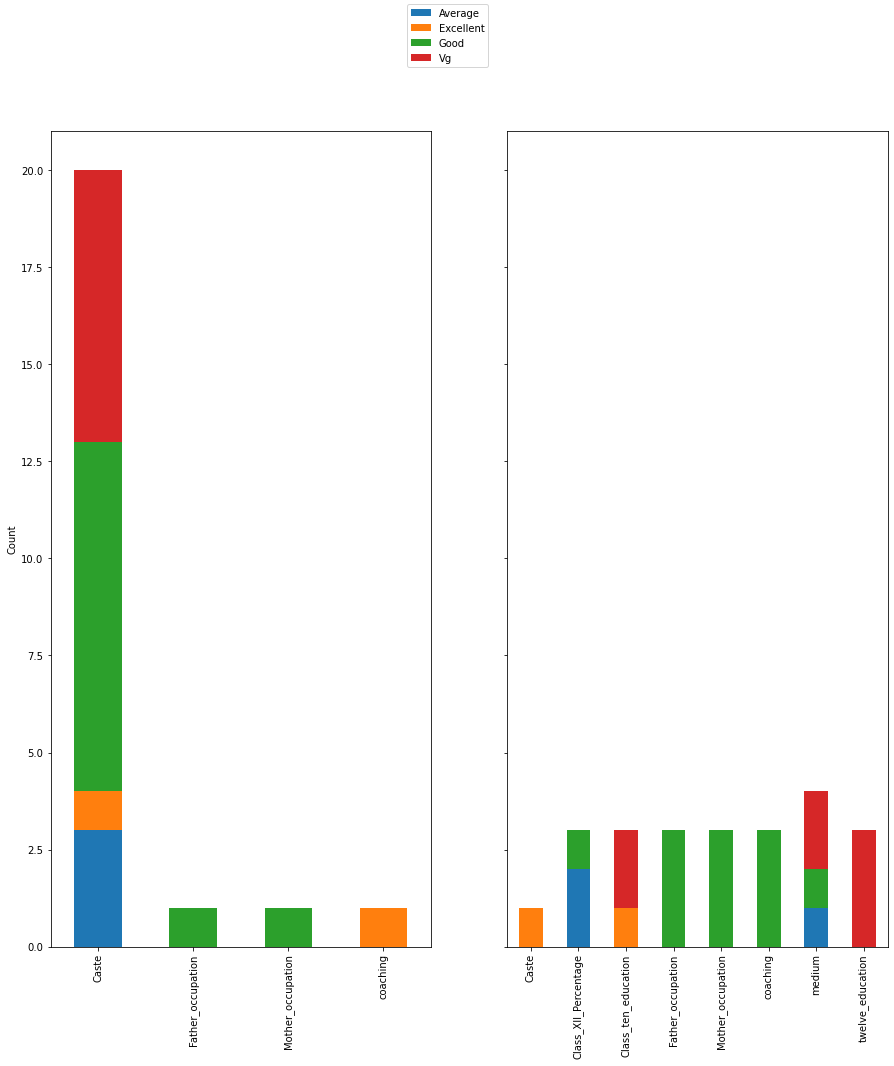

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [27]:
count = 0
feat_names = ['Gender',
    'Caste',
    'coaching',
    'Class_ten_education',
    'twelve_education',
    'medium',
    'Class_X_Percentage',
    'Class_XII_Percentage',
    'Father_occupation',
    'Mother_occupation']
classes = ['Average', 'Excellent', 'Good', 'Vg']
tp = pd.DataFrame(columns=['Class','first_feat','second_feat'])
for d in dat_loc['specific']:
    actual_class = d['perf']['actual']
    if actual_class==d['perf']['predicted']:
        f2 = pd.DataFrame(d['scores'])[actual_class].nlargest(2)
        tp = tp.append({'Class':classes[actual_class], 'first_feat':feat_names[f2.index[0]], 'second_feat':feat_names[f2.index[1]]},ignore_index=True)
        count += 1
print("Number of correctly classified instances: ", count)
fr = tp[['Class','first_feat']].groupby(['first_feat','Class']).size().unstack(fill_value=0)
sc = tp[['Class','second_feat']].groupby(['second_feat','Class']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1,2,figsize=(15,15),sharey=True)

fr.plot(kind='bar',stacked=True,ylabel='Count',xlabel='', ax=axes[0], legend=False)
sc.plot(kind='bar',stacked=True,ylabel='',xlabel='', ax=axes[1], legend=False)
# plt.yticks(np.arange(0, fr.sum().sum(), step=2))
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()
fig.savefig('results-ebm/feat_histo.eps', format='eps')


## Linear Model

In [7]:
# https://interpret.ml/docs/lr.html

from interpret.glassbox import LogisticRegression

lr = LogisticRegression(random_state=seed)
lr.fit(X_train_enc, Y_train_enc)

lr_global = lr.explain_global()
show(lr_global)

/Users/shyaman/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [17]:
# seems this one doesn't support strings for y labels
# lr_local = lr.explain_local(X_test_enc[:5], Y_test_enc[:5])
# show(lr_local)

## Decision tree

In [8]:
from interpret.glassbox import ClassificationTree

dt = ClassificationTree(random_state=seed)
dt.fit(X_train_enc, Y_train_enc)

dt_global = dt.explain_global()
show(dt_global)

In [ ]:
# seems this one doesn't support strings for y labels
# dt_local = dt.explain_local(X_test_enc[:5], Y_test_enc[:5])
# show(dt_local)

## Descision Rule

In [9]:
from interpret.glassbox import DecisionListClassifier

dl = DecisionListClassifier(random_state=seed)
dl.fit(X_train_enc, Y_train_enc)

dl_global = dl.explain_global()
show(dl_global)

/Users/shyaman/miniconda3/envs/ml/lib/python3.9/site-packages/skrules/skope_rules.py:214: UserWarning:

Found labels {0, 1, 2, 3}. This method assumes target class to be labeled as 1 and normal data to be labeled as 0. Any label different from 0 will be considered as being from the target class.



In [ ]:
# seems this one doesn't support strings for y labels
# dl_local = dl.explain_local(X_test_enc[:5], Y_test_enc[:5])
# show(dl_local)